In [8]:
!pip install jinja2 typeguard
!pip install kagglehub

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached markupsafe-3.0.3-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.7 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached markupsafe-3.0.3-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [jinja2]


In [11]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Path to dataset files:", path)

100%|██████████| 658M/658M [03:10<00:00, 3.61MB/s] 


Extracting files...
Path to dataset files: /home/s/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [16]:
!pip install numpy opencv-python scikit-learn keras matplotlib tensorflow



Import neccessary packages

In [22]:
import numpy as np
import pickle
import cv2
from os import listdir
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam


In [23]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/home/s/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1'
width=256
height=256
depth=3

Function to convert images to array

In [24]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [25]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed


Get Size of Processed Image

In [26]:
image_size = len(image_list)

Transform Image Labels uisng Scikit LabelBinarizer

In [27]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [28]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [29]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [30]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [31]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [39]:
from tensorflow.keras.layers import Input

model = Sequential()
model.add(Input(shape=inputShape))
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPU available: []


Model Summary

In [40]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [41]:
opt = Adam(learning_rate=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [42]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 62s 830ms/step - accuracy: 0.2315 - loss: 0.6306 - val_accuracy: 0.1083 - val_loss: 1.6761
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3438 - loss: 0.3545 - val_accuracy: 0.0998 - val_loss: 1.8408
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 58s 793ms/step - accuracy: 0.4497 - loss: 0.2159 - val_accuracy: 0.0643 - val_loss: 1.4751
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5625 - loss: 0.1470 - val_accuracy: 0.0643 - val_loss: 1.3470
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 59s 801ms/step - accuracy: 0.5855 - loss: 0.1542 - val_accuracy: 0.0575 - val_loss: 0.6847
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6562 - loss: 0.1244 - val_accuracy: 0.0491 - val_loss: 0.8205
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 58s 789ms/step - accuracy: 0.6413 - loss: 0.1410 - val_accuracy: 0.0761 - val_loss: 7.0104
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6875 - loss: 0.1232 - val_accuracy: 0.

Plot the train and val curve

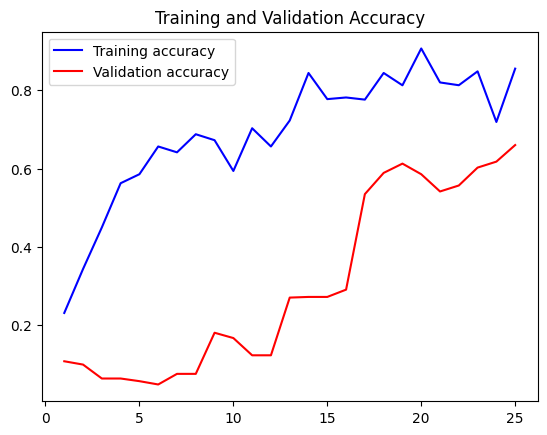

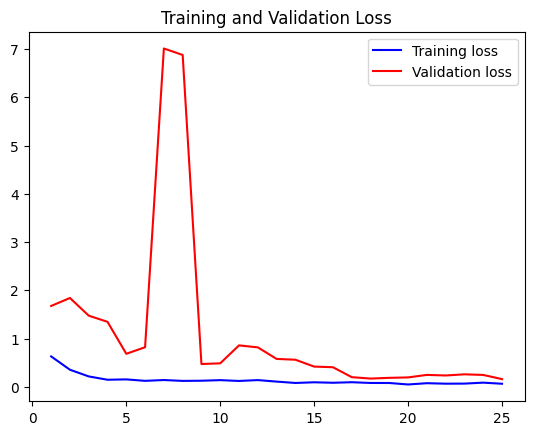

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model Accuracy

In [45]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6599 - loss: 0.1598
Test Accuracy: 65.98984599113464


Save model using Pickle

In [51]:
# save the model to disk
print("[INFO] Saving model...")
model.save("cnn_model.h5")  # or model.save("cnn_model.keras")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


prediction

In [50]:
import pickle
import numpy as np
import cv2

# Load the model
with open("cnn_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load and preprocess the image
image_path = "0fdb66e8-b17d-42c2-bc6d-30dcfab8fcae___JR_B.Spot 9058.JPG"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.resize(image, (width, height))  # Use same dimensions as training
image = image.astype("float") / 255.0       # Normalize if needed
image = np.expand_dims(image, axis=0)       # Add batch dimension

# Make prediction
prediction = model.predict(image)

# If you used LabelBinarizer or MultiLabelBinarizer
with open("label_transform.pkl", "rb") as f:
    lb = pickle.load(f)

# Decode prediction
predicted_label = lb.inverse_transform(prediction)[0]
print("Predicted label:", predicted_label)
print("Raw prediction:", prediction)
print("Decoded label:", lb.inverse_transform(prediction)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted label: Tomato_Bacterial_spot
Raw prediction: [[3.7604240e-01 2.6994650e-07 2.9753363e-02 2.0543705e-06 1.0018449e-06
  5.5534095e-01 1.3273474e-02 1.1234086e-07 4.3120878e-04 4.2433529e-03
  1.4779024e-02 3.7171278e-05 6.0470058e-03 6.2040664e-07 4.8076883e-05]]
Decoded label: Tomato_Bacterial_spot
